In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [28]:
import datajoint as dj
import pathlib
import itertools
import re

dj.config["enable_python_native_blobs"] = True

In [29]:
schema = dj.schema('photonics')

In [30]:
@schema
class Design(dj.Lookup):
    definition = """
    design : smallint     # design number
    ---
    design_title : varchar(255)    
    design_description : varchar(1000)
    design_path    : varchar(255)  
    geometry_file  : varchar(255)
    center_offset  : blob   # offset from legacy implementation
    """
    
    contents = [
        (1, '8-emitter-design', '', 'Design1/matrix_8pix_random_1200x1200x400_15-04-17', 
         'geometry.csv', (600, 600, 0)),
        (3, "Wesley Sacher's shaped fields", "", 
         "Design3/matrix_wesley1_revised_revised_1000x1000x1000_15-12-15", 
         "geometry_beams_as_emitters_wesley1_1000x1000x1000.csv", (550, 510, 0)),
        (4, "Shaped fields with 30-degree-collection cones", 
         "50 emitters per shank, 30-degree emission detection fields", 
         "Design4/matrix_steer_and_collect_a1_b3_v3_16-06-02", 
         "steer_coll_a1_b3_beams_as_emitters_geometry.csv", (550, 510, 0)),
    ]

In [31]:
Design()

design design number,design_title,design_description,design_path,geometry_file,center_offset offset from legacy implementation
1,8-emitter-design,,Design1/matrix_8pix_random_1200x1200x400_15-04-17,geometry.csv,=BLOB=
3,Wesley Sacher's shaped fields,,Design3/matrix_wesley1_revised_revised_1000x1000x1000_15-12-15,geometry_beams_as_emitters_wesley1_1000x1000x1000.csv,=BLOB=
4,Shaped fields with 30-degree-collection cones,"50 emitters per shank, 30-degree emission detection fields",Design4/matrix_steer_and_collect_a1_b3_v3_16-06-02,steer_coll_a1_b3_beams_as_emitters_geometry.csv,=BLOB=


In [32]:
@schema
class Technical(dj.Computed):
    definition = """  # technical characteristics of probe designs
    -> Design
    ---
    max_emitter_power :float   # (uW) max power, averaged over pulse period
    dark_photon_rate :float  # (photons/sec)
    """

    def make(self, key):
        self.insert1(dict(key, max_emitter_power=100, dark_photon_rate=300))

In [33]:
Technical()

design design number,"max_emitter_power (uW) max power, averaged over pulse period",dark_photon_rate (photons/sec)


In [34]:
@schema
class Geometry(dj.Imported):
    definition = """
    -> Design
    ---
    """
    
    class Emitter(dj.Part):
        definition = """  # subtable of Geometry
            -> master
            emitter :smallint
            ----
            e_center_x   :float  # um
            e_center_y   :float  # um
            e_center_z   :float  # um
            e_norm_x : float 
            e_norm_y : float 
            e_norm_z : float 
            e_top_x : float 
            e_top_y : float 
            e_top_z : float 
            e_height : float  # um
            e_width  : float  # um
            e_thick  : float  # um            
            """
        
    class Detector(dj.Part):
        definition = """    # subtable of Geometry
            -> master
            detector :smallint
            ----
            d_center_x   :float  # um
            d_center_y   :float  # um
            d_center_z   :float  # um
            d_norm_x : float 
            d_norm_y : float 
            d_norm_z : float 
            d_top_x : float 
            d_top_y : float 
            d_top_z : float 
            d_height : float  # um
            d_width  : float  # um
            d_thick  : float  # um            
            """

    class Shank(dj.Part):
        definition = """  # subtable of Geometry
            -> master
            shank : smallint
            ----
            shank_x   : float   # um
            shank_y   : float   # um
            """

    def make(self, key):
        self.insert1(key)
        legacy_filepath = '../legacy/matrices'
        detector_pattern = re.compile(r'Detector,"\((?P<center>.*)\)","\((?P<normal>.*)\)","\((?P<top>.*)\)",(?P<height>.*),(?P<width>.*),(?P<thick>.*)')
        emitter_pattern = re.compile(r'Emitter,"\((?P<center>.*)\)","\((?P<normal>.*)\)","\((?P<top>.*)\)",(?P<height>.*),(?P<width>.*),(?P<thick>.*)')
        d_count = itertools.count()
        e_count = itertools.count()
        last_rec = {}
        origin = (Design & key).fetch1('center_offset')
        for line in pathlib.Path(legacy_filepath, *(Design & key).fetch1('design_path', 'geometry_file')).open():
            # detectors
            match = detector_pattern.match(line)
            if match:
                rec = dict(key, detector=next(d_count))
                rec.update(zip(('d_center_x','d_center_y','d_center_z'), 
                               (float(i)-offset for i, offset in zip(match['center'].split(','), origin))))
                rec.update(zip(('d_norm_x','d_norm_y','d_norm_z'), 
                               (float(i) for i in match['normal'].split(','))))
                rec.update(zip(('d_top_x','d_top_y','d_top_z'), 
                               (float(i) for i in match['normal'].split(','))))
                rec.update(
                    d_height=float(match['height']), 
                    d_width=float(match['width']),
                    d_thick=float(match['thick']))
                self.Detector.insert1(rec)
                continue
                
            # emitters
            match = emitter_pattern.match(line)
            if match:
                rec = dict(key)
                rec.update(zip(('e_center_x','e_center_y','e_center_z'), 
                               (float(i)-offset for i, offset in zip(match['center'].split(','), origin))))
                rec.update(zip(('e_norm_x','e_norm_y','e_norm_z'), 
                               (float(i) for i in match['normal'].split(','))))
                rec.update(zip(('e_top_x','e_top_y','e_top_z'), 
                               (float(i) for i in match['normal'].split(','))))
                rec.update(
                    e_height=float(match['height']), 
                    e_width=float(match['width']),
                    e_thick=float(match['thick']))
                if rec != last_rec:
                    self.Emitter.insert1(dict(rec, emitter=next(e_count)))
                    last_rec = rec
                continue

In [36]:
Geometry.populate()

In [37]:
Geometry.aggr(Geometry.Emitter(), n='count(*)')

design design number,n calculated attribute
1,1296
3,850
4,850


In [38]:
7650/9

850.0

In [39]:
set(zip(*(Geometry.Emitter() & 'design=4').fetch('e_height', 'e_width')))

{(10.0, 10.0)}

In [40]:
set(zip(*(Geometry.Detector() & 'design=1').fetch('d_height', 'd_width')))

{(50.0, 10.0)}

In [41]:
max(zip(*(Geometry.Detector() & 'design=3').fetch('d_center_z', 'd_center_x')))

(980.0, 350.0)

# Design 1 Geometry

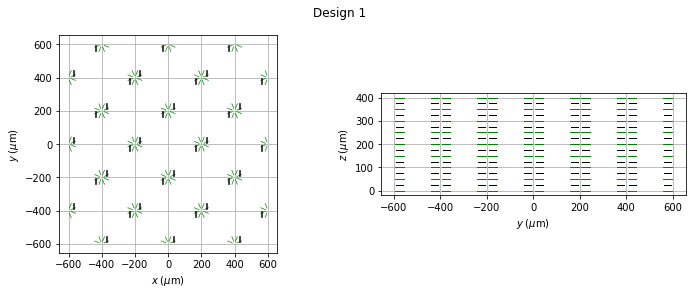

In [42]:
r = {'design': 1}
fig, axx = plt.subplots(1, 2, figsize=(12,4))

ax = axx[0]

ax.set_aspect('equal')
ax.set_xlabel(r'$x\; (\mu\mathsf{m})$', fontsize=10)
ax.set_ylabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
ax.set_xticks(np.r_[-600:601:200])
ax.set_yticks(np.r_[-600:601:200])
ax.grid(True)

_ = (Geometry.Emitter & 'design=1').fetch('e_center_x', 'e_center_y', 'e_norm_x', 'e_norm_y')
for x, y, nx, ny in zip(*_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'g', alpha=0.2, lw=0.5)

_ = (Geometry.Detector & 'design=1').fetch('d_center_x', 'd_center_y', 'd_norm_x', 'd_norm_y')
for x, y, nx, ny in zip(*_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'k', alpha=0.2)

    
ax = axx[1]

ax.set_aspect('equal')
ax.set_xlabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
ax.set_ylabel(r'$z\; (\mu\mathsf{m})$', fontsize=10)
ax.grid(True)

_ = (Geometry.Emitter & 'design=1').fetch('e_center_x', 'e_center_z', 'e_norm_x', 'e_norm_z')
for x, z, nx, nz in zip(*_):
    ax.plot((x, x+30*nx), (z, z+30*nz), 'g', lw=0.5)

_ = (Geometry.Detector & 'design=1').fetch('d_center_y', 'd_center_z', 'd_norm_y', 'd_norm_z')
for y, z, ny, nz in zip(*_):
    ax.plot((y, y+30*ny), (z, z+30*nz), 'k', lw=1)

fig.suptitle('Design {design}'.format(**r))


fig.savefig('geometry-1.pdf')

# Designs 3 and 4 
The orientations of pixels (norms) were missing. 

25 shanks with 34 steerable emitters and 33 detectors

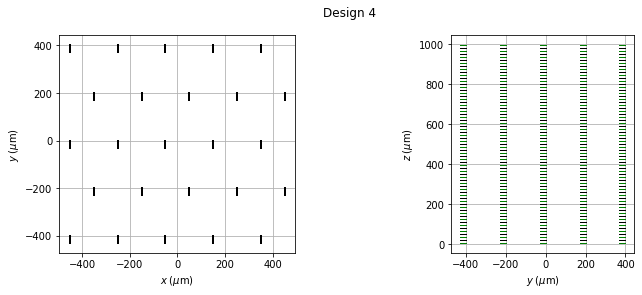

In [43]:
r = {'design': 4}
fig, axx = plt.subplots(1, 2, figsize=(12,4))

ax = axx[0]

ax.set_aspect('equal')
ax.set_xlabel(r'$x\; (\mu\mathsf{m})$', fontsize=10)
ax.set_ylabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
ax.set_xticks(np.r_[-600:601:200])
ax.set_yticks(np.r_[-600:601:200])
ax.grid(True)

_ = (Geometry.Emitter & r).fetch('e_center_x', 'e_center_y', 'e_norm_x', 'e_norm_y')
for x, y, nx, ny in zip(*_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'g-', alpha=0.2, lw=1)

_ = (Geometry.Detector & r).fetch('d_center_x', 'd_center_y', 'd_norm_x', 'd_norm_y')
for x, y, nx, ny in zip(*_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'k-', alpha=0.2)
    
ax = axx[1]

ax.set_aspect('equal')
ax.set_xlabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
ax.set_ylabel(r'$z\; (\mu\mathsf{m})$', fontsize=10)
ax.grid(True)

_ = (Geometry.Emitter & r).fetch('e_center_y', 'e_center_z', 'e_norm_y', 'e_norm_z')
for y, z, ny, nz in zip(*_):
    ax.plot((y, y+30*ny), (z, z+30*nz), 'g-', lw=1)

_ = (Geometry.Detector & r).fetch('d_center_y', 'd_center_z', 'd_norm_y', 'd_norm_z')
for y, z, ny, nz in zip(*_):
    ax.plot((y, y+30*ny), (z, z+30*nz), 'k-', lw=1)

fig.suptitle('Design {design}'.format(**r))

fig.savefig('geometry-4.pdf')

In [44]:
set(zip(*(Geometry.Emitter & r).fetch('e_norm_x', 'e_norm_y', 'e_norm_z')))

{(0.0, -1.0, 0.0)}

In [45]:
set(zip(*(Geometry.Detector & r).fetch('d_norm_x', 'd_norm_y', 'd_norm_z')))

{(0.0, -1.0, 0.0)}

In [46]:
!open geometry-4.pdf

In [47]:
len(set(zip(*(Geometry.Emitter & r).fetch('e_center_x', 'e_center_y', 'e_center_z'))))

850

In [48]:
len(set(zip(*(Geometry.Detector & r).fetch('d_center_x', 'd_center_y', 'd_center_z'))))

825

In [49]:
825/25

33.0

In [50]:
a = np.array(list(set((Geometry.Detector & r).fetch('d_center_z'))))

In [51]:
a.sort()

In [52]:
a = np.array(list(set((Geometry.Emitter & r).fetch('e_center_z'))))

In [53]:
a.min(), a.max()

(5.0, 995.0)

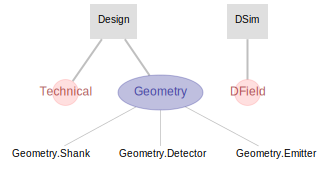

In [55]:
schema.spawn_missing_classes()
dj.Diagram(schema)

In [57]:
Geometry.Detector()

design design number,detector,d_center_x um,d_center_y um,d_center_z um,d_norm_x,d_norm_y,d_norm_z,d_top_x,d_top_y,d_top_z,d_height um,d_width um,d_thick um
1,0,32.5,-190.5,175.0,-0.0,1.0,0.0,-0.0,1.0,0.0,50.0,10.0,2.0
1,1,32.5,-190.5,125.0,-0.0,1.0,0.0,-0.0,1.0,0.0,50.0,10.0,2.0
1,2,32.5,-190.5,75.0,-0.0,1.0,0.0,-0.0,1.0,0.0,50.0,10.0,2.0
1,3,32.5,-190.5,25.0,-0.0,1.0,0.0,-0.0,1.0,0.0,50.0,10.0,2.0
1,4,-32.5,-209.5,175.0,0.0,-1.0,-0.0,0.0,-1.0,-0.0,50.0,10.0,2.0
1,5,-32.5,-209.5,125.0,0.0,-1.0,-0.0,0.0,-1.0,-0.0,50.0,10.0,2.0
1,6,-32.5,-209.5,75.0,0.0,-1.0,-0.0,0.0,-1.0,-0.0,50.0,10.0,2.0
1,7,-32.5,-209.5,25.0,0.0,-1.0,-0.0,0.0,-1.0,-0.0,50.0,10.0,2.0
1,8,32.5,-190.5,225.0,-0.0,1.0,0.0,-0.0,1.0,0.0,50.0,10.0,2.0
1,9,32.5,-190.5,275.0,-0.0,1.0,0.0,-0.0,1.0,0.0,50.0,10.0,2.0


In [63]:
sorted(np.r_[:135*8:135] % 360)

[0, 45, 90, 135, 180, 225, 270, 315]